### Target:

- Add Batch Normalization to increase the model efficiency

### Results:

- Parameters: 13.9K
- Best Training Accuracy: 99.24
- Best Test Accuracy: 99.53

### Analysis:

- By reducing the batch size to 128, observed quicker convergence
- To get a scope of reducing parameters, removed the last 2 layers capping the receptive field at 22
- Larger kernel of size 6x6 is used in the last layer


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [14]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.1325,), (0.3104,))
    ])


# Dataset and Creating Train/Test Split

In [15]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [16]:
SEED = 8

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8170)
 - mean: tensor(-0.0110)
 - std: tensor(0.8580)
 - var: tensor(0.7361)
torch.Size([128, 1, 28, 28])
torch.Size([128])


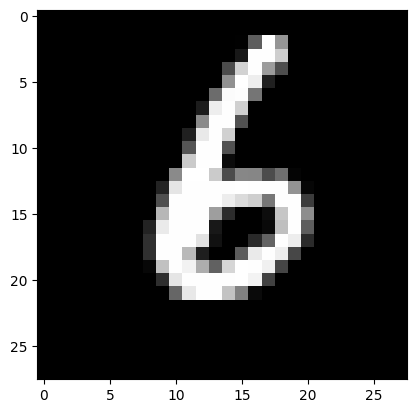

In [17]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray')


origingal


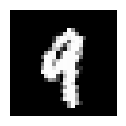

 
centercrop


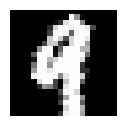

 
resize


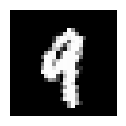

 
rotation


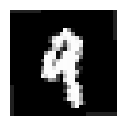

 
normalize


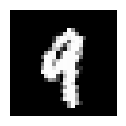

In [18]:
import numpy as np

def plot(imgs, title=None):
    figure = plt.figure(figsize=(5,5))
    num_of_images = len(imgs)
    for index in range(0, num_of_images):
        plt.subplot(4,3,index+1)
        plt.axis('off')
        if title:
            plt.title=title
        plt.imshow(imgs[index].numpy().squeeze(), cmap='gray')
        plt.tight_layout()
        plt.xticks([])
        plt.yticks([])
        plt.show()

batch = next(iter(train_loader))
imgs, labels = batch[0], batch[1]
orig_img, label = imgs[0], labels[0]
orig_img = orig_img.unsqueeze(0)

transformations = {
    'centercrop': transforms.RandomApply([transforms.CenterCrop(20), ], p=1.0),
    'resize': transforms.Resize((28, 28)),
    'rotation': transforms.RandomRotation((-15., 15.), fill=0),
    'normalize': transforms.Normalize((0.1307,), (0.3081,)),
}

print("origingal")
plot(orig_img)

for key, trans in transformations.items():
    print(" ")
    print(key)
    out = trans(orig_img)
    plot(out)

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

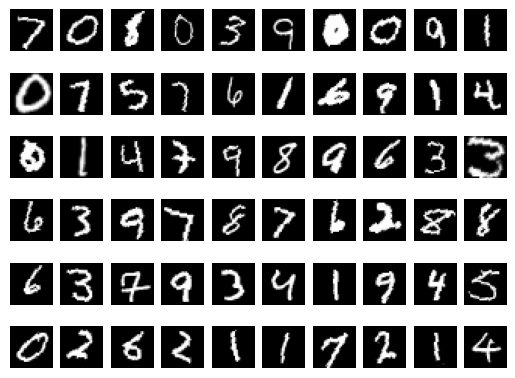

In [19]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray')

# The model
- Let's start with the expand and squeeze model architecture
- The number of channels in a block will keep on increasing. In the transition block, the number of channels will be reduced

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 3, padding=0, bias=False)       # 28 > 26 | 3
        self.batch_norm1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(12, 12, 3, padding=0, bias=False)      # 26 > 24 | 5
        self.batch_norm2 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 12, 3, padding=0, bias=False)      # 24 > 22 | 7
        self.batch_norm3 = nn.BatchNorm2d(12)
        self.conv4 = nn.Conv2d(12, 12, 3, padding=0, bias=False)      # 22 > 20 | 9
        self.batch_norm4 = nn.BatchNorm2d(12)

        self.pool1 = nn.MaxPool2d(2, 2)                               # 20 > 10 | 10

        self.conv5 = nn.Conv2d(12, 16, 3, padding=0, bias=False)      # 10 > 8 | 14
        self.batch_norm5 = nn.BatchNorm2d(16)
        self.conv6 = nn.Conv2d(16, 16, 3, padding=0, bias=False)      #  8 > 6 | 18
        self.batch_norm6 = nn.BatchNorm2d(16)

        self.conv7 = nn.Conv2d(16, 10, 6, padding=0, bias=False)     # 6 > 4 | 22
        # self.batch_norm7 = nn.BatchNorm2d(18)
        # self.conv8 = nn.Conv2d(18, 18, 3, padding=0, bias=False)     # 4 > 2 | 26
        # self.batch_norm8 = nn.BatchNorm2d(18)
        # self.conv9 = nn.Conv2d(18, 10, 2, padding=0, bias=False)     # 2 > 1 | 30

    def forward(self, x):
        x = self.batch_norm1(F.relu(self.conv1(x)))
        x = self.batch_norm2(F.relu(self.conv2(x)))
        x = self.batch_norm3(F.relu(self.conv3(x)))
        x = self.batch_norm4(self.conv4(x))

        x = self.pool1(x)

        x = self.batch_norm5(F.relu(self.conv5(x)))
        x = self.batch_norm6(F.relu(self.conv6(x)))
        # x = self.batch_norm7(F.relu(self.conv7(x)))
        x = self.conv7(x)
        # x = self.batch_norm8(self.conv8(x))
        # x = self.conv9(x)

        x = x.view(-1, 10)                                             # 1x1x10 > 10
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [29]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
       BatchNorm2d-2           [-1, 12, 26, 26]              24
            Conv2d-3           [-1, 12, 24, 24]           1,296
       BatchNorm2d-4           [-1, 12, 24, 24]              24
            Conv2d-5           [-1, 12, 22, 22]           1,296
       BatchNorm2d-6           [-1, 12, 22, 22]              24
            Conv2d-7           [-1, 12, 20, 20]           1,296
       BatchNorm2d-8           [-1, 12, 20, 20]              24
         MaxPool2d-9           [-1, 12, 10, 10]               0
           Conv2d-10             [-1, 16, 8, 8]           1,728
      BatchNorm2d-11             [-1, 16, 8, 8]              32
           Conv2d-12             [-1, 16, 6, 6]           2,304

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [30]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [31]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.12325169891119003 Batch_id=468 Accuracy=94.45: 100%|██████████| 469/469 [00:52<00:00,  8.98it/s]



Test set: Average loss: 0.0412, Accuracy: 9869/10000 (98.69%)

EPOCH: 1


Loss=0.0825781598687172 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:43<00:00, 10.88it/s]



Test set: Average loss: 0.0383, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Loss=0.043501805514097214 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:43<00:00, 10.74it/s]



Test set: Average loss: 0.0305, Accuracy: 9917/10000 (99.17%)

EPOCH: 3


Loss=0.046078577637672424 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:43<00:00, 10.87it/s]



Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)

EPOCH: 4


Loss=0.06566820293664932 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:43<00:00, 10.87it/s]



Test set: Average loss: 0.0257, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.06443355977535248 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:46<00:00, 10.12it/s]



Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)

EPOCH: 6


Loss=0.058543574064970016 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:45<00:00, 10.28it/s]



Test set: Average loss: 0.0207, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.003898977069184184 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:44<00:00, 10.48it/s]



Test set: Average loss: 0.0251, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.01559991855174303 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:43<00:00, 10.81it/s]



Test set: Average loss: 0.0198, Accuracy: 9939/10000 (99.39%)

EPOCH: 9


Loss=0.023173796012997627 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:44<00:00, 10.51it/s]



Test set: Average loss: 0.0196, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.05689041689038277 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:43<00:00, 10.84it/s]



Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 11


Loss=0.0597611702978611 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:43<00:00, 10.81it/s]



Test set: Average loss: 0.0180, Accuracy: 9946/10000 (99.46%)

EPOCH: 12


Loss=0.015056933276355267 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:44<00:00, 10.61it/s]



Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99.44%)

EPOCH: 13


Loss=0.00539930397644639 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:42<00:00, 10.91it/s]



Test set: Average loss: 0.0158, Accuracy: 9953/10000 (99.53%)

EPOCH: 14


Loss=0.07216165959835052 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:42<00:00, 10.93it/s]



Test set: Average loss: 0.0202, Accuracy: 9927/10000 (99.27%)



In [32]:
# train_losses

In [33]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

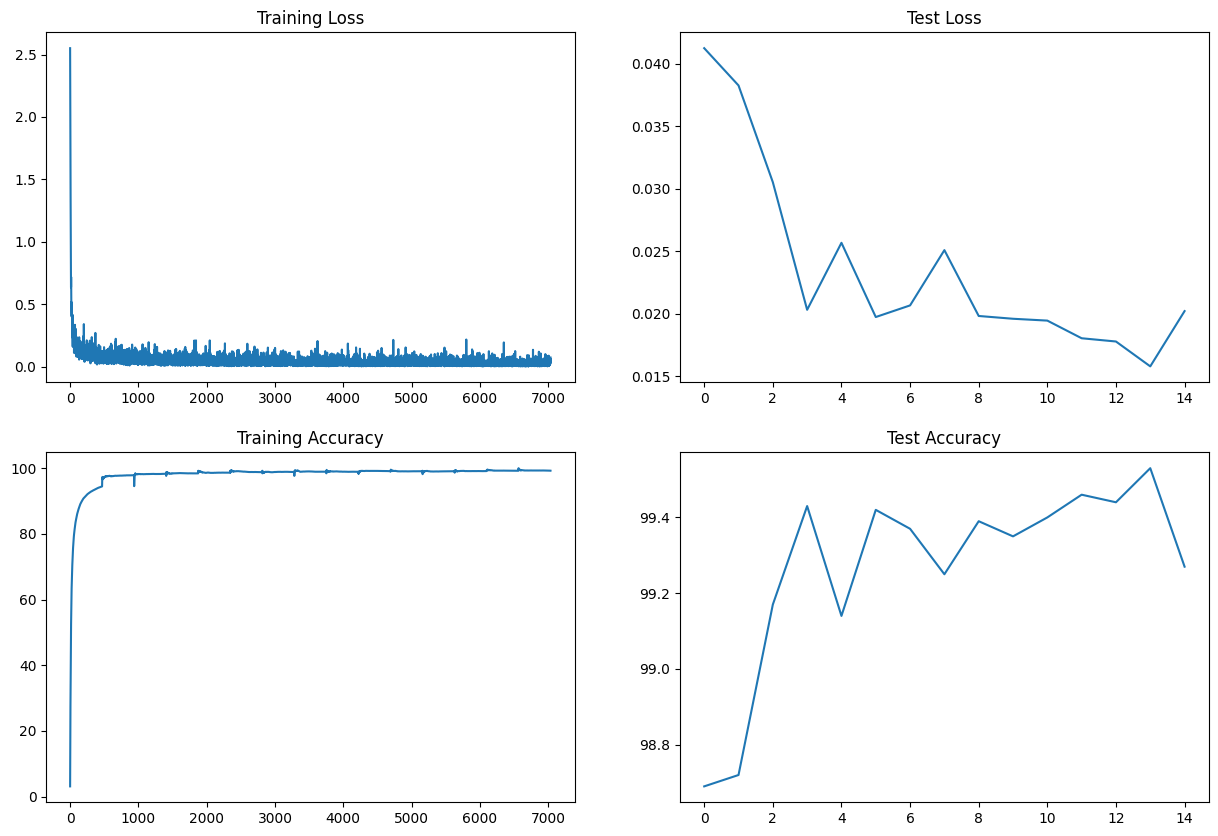

In [34]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")